## 11.1 Stochastic Gradient Descent

In this exercise, we will improve our previous basic MLP by extending it to use stochastic gradient descent and more advanced weight updates. But before we do so, we can also upgrade our dataset to the _California_ Housing dataset! The code below will download this dataset and do a training / validation split into 20000 training samples and 640 validation samples.

We will normalize the features again, but this time we use min-max normalization. Each feature is transformed as follows:

$$ f' = \frac{f - f_\text{min}}{f_\text{max} - f_\text{min}} $$

**Q 11.1.1: What are the differences to Z-Score normalization in 5.2?**

**Answer:** Min-max normalization (also known as feature scaling) has a fixed range of [0;1], while z-score normalization (also known as standardization) is unbounded. On the other hand, z-score normalization centers the data around 0, while min-max scaling does not guarantee this.

In [1]:
import os
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.utils import shuffle

n_training_samples = 20000

# Download the dataset into the notebook directory, if
# it doesn't exist yet
california = fetch_california_housing(data_home=os.getcwd())

# Randomize the order of the samples
data, target = shuffle(california.data, california.target)

# Split into training and validation dataset
X_train = data[:n_training_samples]
y_train = target[:n_training_samples].reshape((-1, 1))
X_valid = data[n_training_samples:]
y_valid = target[n_training_samples:].reshape((-1, 1))

# Determine minimum and maximum of training data
X_min = np.min(X_train, axis=0)
X_max = np.max(X_train, axis=0)
y_min = np.min(y_train)
y_max = np.max(y_train)

# Scale the features accordingly. We want them to be in
# the range[-1, 1], so we multiply with 2 and subtract 1.
X_train = 2 * (X_train - X_min) / (X_max - X_min) - 1
X_valid = 2 * (X_valid - X_min) / (X_max - X_min) - 1
y_train = 2 * (y_train - y_min) / (y_max - y_min) - 1
y_valid = 2 * (y_valid - y_min) / (y_max - y_min) - 1

The following code sets up the neural network and defines its forward and backward pass. It is the same as in the solution to exercise 5.2, so if you are not sure how it works, now would be a good time to find out! Otherwise you can execute it and skip to the next block.

In [2]:
# Define the network architecture
n_input_units = X_train.shape[1]
n_hidden_units = 50
n_output_units = 1

# Every layer is a matrix multiplication plus a bias, so
# the shapes must match those operations.
hidden_weights_shape = (n_input_units, n_hidden_units)
output_weights_shape = (n_hidden_units, n_output_units)
hidden_bias_shape = (1, n_hidden_units)
output_bias_shape = (1, n_output_units)

# For the optimization with gradient descent, we have to pick an
# initial guess for the solution.
def init_weights():
    # We initialize the weights with a Gaussian distribution
    hidden_weights = np.random.standard_normal(hidden_weights_shape) * 0.1
    output_weights = np.random.standard_normal(output_weights_shape) * 0.1

    # The bias is usually initialized to zero
    hidden_bias = np.zeros(hidden_bias_shape)
    output_bias = np.zeros(output_bias_shape)

    return hidden_weights, output_weights, hidden_bias, output_bias
    
hidden_weights, output_weights, hidden_bias, output_bias = init_weights()
    
# Activation functions
def relu(x):
    # It's important to use the elementwise max function in numpy
    return np.maximum(0., x)

def linear(x):
    return x

# The forward pass for this neural network
# The output for every layer should be computed in
# two steps: before and after applying the activation
# function.
def forward_pass(X):
    hidden_linear = X.dot(hidden_weights) + hidden_bias
    hidden_act = relu(hidden_linear)
    
    output_linear = hidden_act.dot(output_weights) + output_bias
    output_act = linear(output_linear)
    
    # We collect the activations in a dictionary here,
    # because we need them for the backward pass
    activations = {
        'hidden_linear': hidden_linear,
        'hidden_act': hidden_act,
        'output_linear': output_linear,
        'output_act': output_act
    }
    
    # The prediction is in output_act
    return output_act, activations

# Loss function
# Implement the mean square error function
def squared_error(y_predicted, y):
    return np.mean(0.5 * (y_predicted - y)**2)

# For the backward pass, we will need the
# derivatives of the activation functions and the loss function
# The gradients are defined in the slides, we just need to match
# the input shapes.
def relu_grad(x):
    dx = np.zeros_like(x)
    dx[x > 0] = 1.
    return dx

def linear_grad(x):
    return np.ones_like(x)

# The error gradient wrt the predicted y value
def squared_error_grad(y_hat, y):
    n_samples = float(y.shape[0])
    return (y_hat - y) / n_samples

# The backward pass is responsible for calculating the derivatives
# of the loss with respect to the weights and biases of each layer.
# It also helps to think about the shapes (again!)
def  backward_pass(X, y, activations):  
    # The first thing to calculate is the gradient of the error function wrt
    # the prediction the network made
    error_grad = squared_error_grad(activations['output_act'], y)
    
    # Now we can go backwards layer by layer
    # First derive wrt the activation function, because it is the last thing we did in
    # the forward pass
    output_act_grad = error_grad * linear_grad(activations['output_linear']) 
    
    # Two objects contributed to Xw + b: the weights and the bias
    # These are the parameters of our network and will let us update
    # the network later.
    output_weights_grad = activations['hidden_act'].T.dot(output_act_grad)
    
    # Remember that the bias was broadcasted from its shape (1, k) to 
    # (n, k) with n being the number of samples. For the correct gradient
    # you need to get back to (1, k) by summing up.
    output_bias_grad = output_act_grad.sum(axis=0, keepdims=True)
    
    # The last thing to do for the output layer is to take the derivative wrt
    # its input, so we can backpropagate the errors the previous layers need
    # to fix.
    output_inp_grad = output_act_grad.dot(output_weights.T)

    # From here on, everything is the same as for the output layer, except
    # for the changed activation function
    hidden_act_grad = output_inp_grad * relu_grad(activations['hidden_linear'])
    hidden_weights_grad = X.T.dot(hidden_act_grad)
    hidden_bias_grad = hidden_act_grad.sum(axis=0, keepdims=True)
    
    # These are the gradients we care about in the end, because
    # we need them to update our network
    gradients = (
        output_weights_grad,
        output_bias_grad,
        hidden_weights_grad,
        hidden_bias_grad
    )
    
    return gradients

Stochastic gradient descent relies on using fewer samples to estimate the gradient in the backward pass. The code below still performs full-batch gradient descent as in the previous exercise, but has been restructured a little bit. Get familiar with it and try it out before you solve the tasks.

** Task a): Implement mini-batch training**

Change the training loop in the code below to go through the training data in mini-batches of 100 samples each. Adjust the training loss to reflect the average error over the mini-batches.



** Q 11.1.2: How does mini-batch training influence the number of weight updates? **

**Answer:** 

$$ \#\text{weight updates} = \frac{\# \text{training samples}}{\# \text{mini-batch size}} \cdot \# \text{epochs} = \# \text{mini-batches} \cdot \# \text{epochs}$$

** Q 11.1.3: How do the training time in seconds and the performance change? **

**Answer:** Theoretically, the time for one epoch increases, because we're doing several forward and backward passes now, but mostly because we're performing more weight updates. In our example and most cases this is barely noticeable though. On the other hand, the network will converge more quickly and possibly reach a better performance.

----------------------

** Task b): Implement Adam**

Change the `update_network` function to perform adaptive moment (adam) weight updates. Use the default parameters from the [deep learning book (p. 311)](http://www.deeplearningbook.org/contents/optimization.html), except for $\rho_2 = 0.95$.

_Python hints_: 

  * To focus on the actual implementation here, we use the [global](http://www.python-course.eu/python3_global_vs_local_variables.php) keyword to keep track of $t$.
  * In the `update_network` function, assign updated values via `"parameters[i][:] = "` and not `"parameters[i] = "`. The first variant changes the underlying object, while the second simply assigns a new object to the list element. Check the vanilla gradient descent variant for an example. The same should be done for the running means!

** Q 11.1.4: Why does Adam fit to SGD? **

**Answer:**

Using fewer samples leads to noisier gradient estimates. Therefore the weight updates might change the network in a way which benefits this mini-batch, but increases the error for other samples. Keeping a running mean of the gradient and the squared gradient (= uncentered variance) smoothes this out, i.e. one mini-batch only contributes a part to the overall gradient estimation. Additionally, we consider the variance when determining the step size. If we're facing high variance in the gradients, i.e. high noise, we are more careful with our weight changes. For low variance on the other hand, we can take larger steps, because we are certain that we will improve the performance in the direction of the gradient. This is an example of using a [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio). Since mini-batches decrease the signal-to-noise-ratio, we can counteract this with Adam and still have the benefit of doing more updates than with full-batch estimates.

** Q 11.1.5: What is the difference in space complexity between Adam and vanilla gradient descent?**

Adam additionally stores running means of the gradient and the squared gradient, so if we have $n$ parameters, the required storage is always $2n$.

Gradient estimation method: full
Weight update method: vanilla


<IPython.core.display.Javascript object>


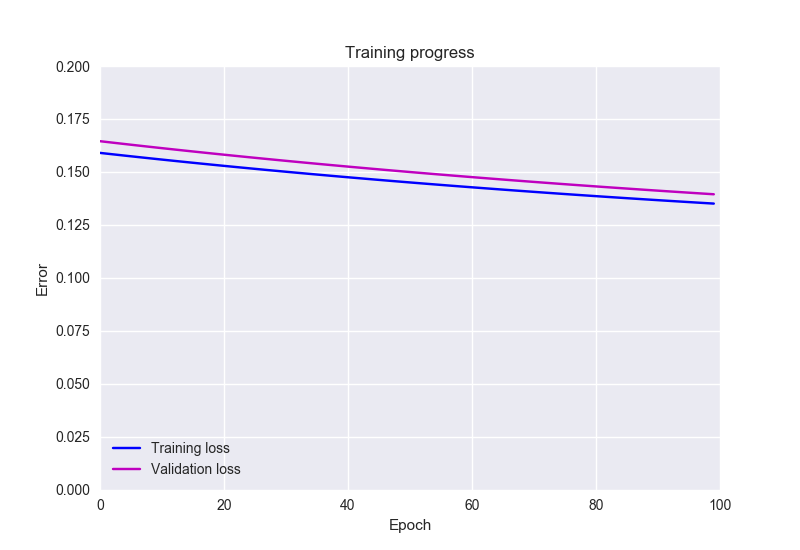

Results:
	Final training loss: 0.13502
	Final validation loss: 0.13943

	Average epoch time: 0.030s
	Training duration: 3.006s


In [3]:
# If you have matplotlib 1.5 or higher, we can use live plotting!
import matplotlib as mpl
if float(mpl.__version__[:3]) >= 1.5:
    %matplotlib notebook
else:
    %matplotlib inline
    
import matplotlib.pyplot as plt
import seaborn
import time

# Hyperparameters
n_epochs = 100
learning_rate = 1e-3

# Decide on the gradient estimation method. Should be 'full' or 'mini'.
# After implementing a) you can switch here between both methods.
batch_method = 'full'
minibatch_size = 100

# Decide on the update method. Should be 'vanilla' or 'adam'
# After implementing b) you can switch here between both methods.
update_method = 'vanilla'

# Hyperparameters for Adam
# TODO b)
step_size = 1e-3
grad_decay = 0.9
grad_squared_decay = 0.95
delta = 1e-8

# Describes how many epochs are done without plotting
# In case the plotting takes too much performance, you can set it higher
# update_plot > n_epochs disables plotting.
update_plot = 1

# We keep track of training and validation error
# for every episode.
training_loss = np.ones(n_epochs) * np.nan
valid_loss = np.ones(n_epochs) * np.nan
epoch_time = np.ones(n_epochs) * np.nan

# Storing the parameters in a list for simple access
hidden_weights, output_weights, hidden_bias, output_bias = init_weights()
parameters = [output_weights, output_bias, hidden_weights, hidden_bias]

# Plotting code:
# This time we update the plot live during training.
# Before we start training, let's also print the current methods
print('Gradient estimation method: {:s}'.format(batch_method))
print('Weight update method: {:s}'.format(update_method))
fig, ax = plt.subplots(1, 1)
ax.set_title('Training progress')
ax.set_xlim([0, n_epochs])
ax.set_ylim([0, 0.5])
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
def plot(ax):
    if ax.lines:
        ax.lines[0].set_ydata(training_loss)
        ax.lines[1].set_ydata(valid_loss)
        ax.set_ylim([0,  0.2])
    else:
        ax.plot(training_loss, c='b', label='Training loss')
        ax.plot(valid_loss, c='m', label='Validation loss')
        ax.legend(loc='lower left')
    fig.canvas.draw()
# -- end of plotting code

# Bookkeeping for Adam
t = 0

# Create the running means for the gradients and squared gradients
# with list comprehensions. This is a quick notation to loop through
# every element in the parameters list
s = [np.zeros_like(p) for p in parameters]
r = [np.zeros_like(p) for p in parameters]
    
# Update the parameters of the network given the gradients
# from the backward pass
def update_network(gradients, parameters):
    
    # First determine which update method is going to be used
    if update_method.lower() == 'adam':
        global t # Let's you set t in this function
        t += 1
        
        # TODO b) Implement Adam
        for i, grad in enumerate(gradients):
            # Update the running means
            s[i][:] = grad_decay * s[i] + (1 - grad_decay) * grad
            r[i][:] = grad_squared_decay * r[i] + (1 - grad_squared_decay) * grad**2
            
            # Correct the initial bias
            s[i][:] = s[i] / (1 - grad_decay**t)
            r[i][:] = r[i] / (1 - grad_squared_decay**t)
        
            # Update the weights with the ratio of the means
            weight_update = -step_size * s[i] / (np.sqrt(r[i]) + delta)
            parameters[i][:] = parameters[i] + weight_update
        
    else:
        # For the vanilla gradient descent update, we can simply
        # loop through the gradients and parameters and update
        # them with the scaled gradient
        for i, grad in enumerate(gradients):
            # Be careful to use the same notation to assign the parameters!
            # Taking the slice with [:] means changing the underlying object,
            # while = assigns a new one.
            parameters[i][:] = parameters[i] - learning_rate * grad

# Define the number of minibatches, so we can loop over them easily
n_minibatches = X_train.shape[0] // minibatch_size

# The training loop
for i in range(n_epochs):
    start = time.time()

    # Decide on the method we use to estimate the gradient
    if batch_method.lower() == 'mini':
        # TODO a) Implement mini-batch training
        
        # Randomize the order of the training samples
        X_train, y_train = shuffle(X_train, y_train)
        
        loss = 0. # Store the error for this epoch
        
        # Loop over the minibatches
        for j in range(n_minibatches):
            # Determine the sample slice for this minibatch
            batch_start = j * minibatch_size
            batch_end = (j + 1) * minibatch_size
        
            # Extract the batch from the training set
            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]   # if batch_end too large --> gets ignored by numpy
        
            # Get the gradient via forward and backward pass
            y_batch_pred, activations = forward_pass(X_batch)
            gradients = backward_pass(X_batch, y_batch, activations)
            
            # Update the parameters with the mini-batch gradient
            update_network(gradients, parameters) 
        
            # Remember the loss of this batch for later
            loss += squared_error(y_batch_pred, y_batch)

        
        # TODO a): adjust the loss to reflect the mini-batch setting
        # To get the mean for this epoch, we simply need to divide
        # by the number of minibatches we looked at.
        training_loss[i] = loss / n_minibatches
        
    else:
        # For the full batch case, we use all the training samples
        # to estimate the gradient
        y_pred, activations = forward_pass(X_train)
        gradients = backward_pass(X_train, y_train, activations)
    
        # Update the parameters of the network with the gradients
        # we just computed.
        update_network(gradients, parameters) 
    
        # Save the training loss for this epoch
        training_loss[i] = squared_error(y_pred, y_train)
    
    # Measure the time it took to perform the training in this epoch
    epoch_time[i] = time.time() - start
    
    # Evaluate the validation set and save the loss for later
    y_pred_valid, _ = forward_pass(X_valid)
    valid_loss[i] = squared_error(y_pred_valid, y_valid)
    
    # Update the plot
    if i % update_plot == 0 or i == n_epochs - 1:
        plot(ax)
        
# Print statistics about the training process
print('Results:')
print('\tFinal training loss: {:.5f}'.format(training_loss[-1]))
print('\tFinal validation loss: {:.5f}'.format(valid_loss[-1]))
print('\n\tAverage epoch time: {:.3f}s'.format(np.mean(epoch_time)))
print('\tTraining duration: {:.3f}s'.format(np.sum(epoch_time)))